In [9]:
import sys
sys.path.append('./')
sys.path.append('./../../../../')
sys.path.append('./../../../../designer')
sys.path.append('./../../../../designer/script')

from spectrum import Spectrum
from film import MultiMaterialFilm, TwoMaterialFilm
from optimizer.adam import AdamThicknessOptimizer
from optimizer.archive.LM_gradient_descent import LM_optimize_d_simple
from design import BaseDesign

from utils.substitute import optimal_and_thin_film_approx_substitution_onestep_new, equal_optical_thickness_new, equal_optical_thickness
from utils.loss import calculate_RMS

import numpy as np
import matplotlib.pyplot as plt
import copy

In [129]:
wls = np.linspace(390, 710, 320)
wls_more = np.linspace(300, 800, 500)

target_spec_params = 20., wls
target = Spectrum(*target_spec_params, np.ones_like(wls))

reverse = lambda arr: np.ascontiguousarray(np.flip(arr))
d_init = reverse(np.loadtxt('./before')) # NOTE: the structures are in the reverse order
materials_init = reverse(np.loadtxt('./before_materials', dtype='str'))
d_eqot_benchmark = reverse(np.loadtxt('./after'))
materials_eqot_benchmark = reverse(np.loadtxt('./after_materials', dtype='str'))

print(materials_eqot_benchmark)
print(d_eqot_benchmark)

film_init = MultiMaterialFilm(materials_init, 1.5, d_init)
# xc
film_eqot_benchmark = MultiMaterialFilm(materials_eqot_benchmark, 1.5, d_eqot_benchmark)
# ours
film_eqot = copy.deepcopy(film_init)
film_optim = copy.deepcopy(film_init)


all_films = [film_init, film_eqot_benchmark, film_eqot, film_optim]
for film in all_films:
    film.add_spec_param(*target_spec_params)

['MgF2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc'
 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc' 'Ta2O5_xc' 'SiO2_xc']
[ 93.333 117.232  51.859   5.183 135.813  11.153 207.212  24.928  12.108
  90.294  31.529  15.26   97.318]


In [130]:
# w/o GD. NOTE: need to wait for compilation of CUDA at first run
d_min = 5.
equal_optical_thickness_new(film_eqot, d_min)
res = optimal_and_thin_film_approx_substitution_onestep_new(film_optim, d_min)
print(res)
print(calculate_RMS(film_optim, film_init))
print(calculate_RMS(film_eqot, film_init))

(2, [(1.004999652853685+0j), (1.158085338751609+0j)])
0.0038453951461807933
0.003828417030051557


(0.0, 1.0)

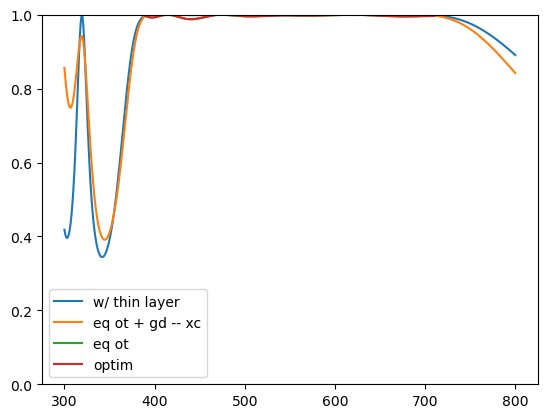

In [131]:
fig, ax = plt.subplots(1, 1)

ax.plot(wls_more, film_init.get_spec(20., wls_more).get_T(), label='w/ thin layer')
ax.plot(wls_more, film_eqot_benchmark.get_spec(20., wls_more).get_T(), label='eq ot + gd -- xc')
ax.plot(wls, film_eqot.get_spec().get_T(), label='eq ot')
ax.plot(wls, film_optim.get_spec().get_T(), label='optim')
ax.legend()
ax.set_ylim(0., 1)



This is weird. In our other experiments optim method seems to greatly outperform the equal ot...

Okay so i guess it is simply bad luck. Our strategy could not offer a result consistently outperforming eqot.

[109.76270079 143.03787327 120.55267521 108.9766366   84.73095987
 129.17882261  87.51744225 178.35460016 192.7325521   76.68830377
 158.34500762 105.77898395 113.60891222 185.11932766   1.
  17.42585994   4.04367949 166.52396911 155.63135019 174.00242965]
[109.76270079 143.03787327 120.55267521 108.9766366   84.73095987
 129.17882261  87.51744225 178.35460016 192.7325521   76.68830377
 158.34500762 105.77898395 113.60891222 203.99358873   4.04367949
 166.52396911 155.63135019 174.00242965]
optim sub res: (1, [(1.0287370874342985+0j)])
0.0046929518278641886
0.004649374890359063


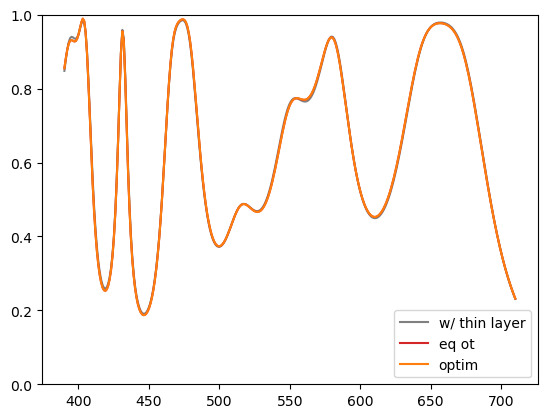

In [124]:
# toy scenario

d_min = 1
layer_number = 20
thin_number = 1

np.random.seed(0)
d_init = np.random.random(layer_number) * 200

thin_idx = np.arange(1, layer_number - 1)
np.random.shuffle(thin_idx)
thin_idx = thin_idx[:thin_number]

d_init[thin_idx] = d_min # artificial thin films
print(d_init)

film = TwoMaterialFilm('Ta2O5_xc', 'SiO2_xc', 'BK7', d_init)
film.add_spec_param(20., wls)

film_eqot = copy.deepcopy(film)
equal_optical_thickness_new(film_eqot, d_min + 1)
print(film_eqot.get_d())

film_optim = copy.deepcopy(film)
res = optimal_and_thin_film_approx_substitution_onestep_new(film_optim, d_min + 1)
print('optim sub res:', res)
fig, ax = plt.subplots(1, 1)

ax.plot(wls, film.get_spec().get_T(), label='w/ thin layer', c='grey')
ax.plot(wls, film_eqot.get_spec().get_T(), label='eq ot', c='C3')
ax.plot(wls, film_optim.get_spec().get_T(), label='optim', c='C1')
ax.legend()
ax.set_ylim(0., 1)

print(calculate_RMS(film, film_optim))
print(calculate_RMS(film, film_eqot))